In [1]:
from os import path
import os
import datetime 
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from shyft.hydrology.repository import interfaces
from pathlib import Path
import pandas as pd
from typing import Union
import pyproj
from typing import Dict, Any
from functools import partial
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import transform
import shyft.hydrology as api
from shyft.hydrology.pt_gs_k import PTGSKModel
import shyft.time_series as sts
from shyft.hydrology import shyftdata_dir
from shyft.hydrology.orchestration.configuration.config_interfaces import RegionConfig, ModelConfig, RegionConfigError
from shyft.hydrology.orchestration.configuration.dict_configs import DictModelConfig, DictRegionConfig
from shyft.hydrology.repository.netcdf.utils import create_ncfile, make_proj
import h5py

from shyft.hydrology.repository.default_state_repository import DefaultStateRepository
from shyft.hydrology.orchestration.configuration.yaml_configs import YAMLSimConfig
from shyft.hydrology.orchestration.simulators.config_simulator import ConfigSimulator

In [2]:
# try to auto-configure the path, -will work in all cases where doc and data
# are checked out at same level
from shyft.hydrology import shyftdata_dir

# shyftdata_dir should be set before starting jupyter notebook with shell command:
# $ export SHYFT_DATA = "path_to_shyft_data" 
# this export command can be added to ~/.bashrc profile


shyft_data_path = os.path.abspath("../../../../shyft-data/")
if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path
    
# shyft should be available either by it's install in python
# or by PYTHONPATH set by user prior to starting notebook.
# This is equivalent to the two lines below
#  shyft_path=path.abspath('../../../shyft')
#  sys.path.insert(0,shyft_path)

In [3]:
shyft_data_path = '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data'

In [4]:
# set up configuration using *.yaml configuration files
# here is the *.yaml file that configures the simulation:
#config_file_path = shyft_data_path + "/budhi_gandaki/yaml_config/budhi_gandaki_simulation.yaml"

config_file_path = shyft_data_path + "/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_simulation_tin.yaml"
# and here we pass it to the configurator, together with the name of the region 
# stated in the simulation.yaml file (here: "neanidelva") which we would like to run
cfg = YAMLSimConfig(config_file_path, "budhi_gandaki")

FileNotFoundError: [Errno 2] No such file or directory: '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_simulation_tin.yaml'

In [5]:

def get_land_type(rgb, land_covers_available)->(int,str):
    for (v,n,r,g,b) in land_covers_available:
        rgbs = (r,g, b)
        (value,name) = (v,n)
        if rgb == rgbs:
            return (value,name)
        else:
            pass


class CFRegionModelRepositoryError(Exception):
    pass


class CFRegionModelRepository(interfaces.RegionModelRepository):
    """
    Repository that delivers fully specified shyft api region_models
    based on data found in netcdf files.
    """

    def __init__(self, region, model):
        """
        Parameters
        ----------
        region: either a dictionary suitable to be instantiated as a
            RegionConfig Object or a sublcass of the interface RegionConfig
            containing regional information, like
            catchment overrides, and which netcdf file to read
        model: either a dictionary suitable to be instantiated as a
            ModelConfig Object or a subclass of interface ModelConfig
            Object containing model information, i.e.
            information concerning interpolation and model
            parameters
        """

        if not isinstance(region, RegionConfig):
            region_config = DictRegionConfig(region)
        if not isinstance(model, ModelConfig):
            model_config = DictModelConfig(model)
        else:
            region_config = region
            model_config = model

        if not isinstance(region_config, RegionConfig) or \
                not isinstance(model_config, ModelConfig):
            raise interfaces.InterfaceError()
        self._rconf = region_config
        self._mconf = model_config
        self._region_model = model_config.model_type()  # region_model
        self._mask = None
        self._epsg = self._rconf.domain()["EPSG"]  # epsg
        self._tin_uid_ = self._rconf.repository()["params"]["tin_uid"]
        filename = self._rconf.repository()["params"]["data_file"]
        filename = path.expandvars(filename)
        if not path.isabs(filename):
            # Relative paths will be prepended the data_dir
            filename = path.join(shyftdata_dir, filename)
        # if not path.isfile(filename):
        #     raise CFRegionModelRepositoryError("No such file '{}'".format(filename))
        tinfolder = self._rconf.repository()["params"]["tin_data_folder"]
        tinfolder = path.expandvars(tinfolder)
        if not path.isabs(tinfolder):
            # Relative paths will be prepended the data_dir
            tinfolder = path.join(shyftdata_dir, tinfolder)
        if not path.isdir(tinfolder):
            raise CFRegionModelRepositoryError("No such file folder '{}'".format(tinfolder))
        self._data_file = filename
        self._tin_data_folder = tinfolder
        self._catch_ids = self._rconf.catchments()
        self._get_from_tin_ = self._rconf.repository()["params"]["get_model_from_tin_repo"]
        self.bounding_box = None

    def _limit(self, x, y, data_cs, target_cs):
        """
        Parameters
        ----------
        """
        # Get coordinate system for arome data
        data_proj = make_proj(data_cs)
        target_proj = make_proj(target_cs)

        # Find bounding box in arome projection
        bbox = self.bounding_box
        bb_proj = pyproj.transform(target_proj, data_proj, bbox[0], bbox[1])
        x_min, x_max = min(bb_proj[0]), max(bb_proj[0])
        y_min, y_max = min(bb_proj[1]), max(bb_proj[1])

        # Limit data
        xy_mask = ((x <= x_max) & (x >= x_min) & (y <= y_max) & (y >= y_min))

        xy_inds = np.nonzero(xy_mask)[0]

        # Transform from source coordinates to target coordinates
        xx, yy = pyproj.transform(data_proj, target_proj, x, y)

        return xx, yy, xy_mask, xy_inds

    def get_region_model(self, region_id, catchments=None):
        """
        Return a fully specified shyft api region_model for region_id, based on data found
        in netcdf dataset.

        Parameters
        -----------
        region_id: string
            unique identifier of region in data

        catchments: list of unique integers
            catchment indices when extracting a region consisting of a subset
            of the catchments has attribs to construct params and cells etc.

        Returns
        -------
        region_model: shyft.api type
        """

        if not (self._get_from_tin_):
            with Dataset(self._data_file) as dset:
                Vars = dset.variables
                c_ids = Vars["catchment_id"][:]
                xcoord = Vars['x'][:]
                ycoord = Vars['y'][:]
                m_catch = np.ones(len(c_ids), dtype=bool)
                if self._catch_ids is not None:
                    m_catch = np.in1d(c_ids, self._catch_ids)
                    xcoord_m = xcoord[m_catch]
                    ycoord_m = ycoord[m_catch]

                dataset_epsg = None
                if 'crs' in Vars.keys():
                    dataset_epsg = Vars['crs'].epsg_code.split(':')[1]
                if not dataset_epsg:
                    raise interfaces.InterfaceError("netcdf: epsg attr not found in group elevation")

                target_cs = f"EPSG:{self._epsg}"
                source_cs = f"EPSG:{dataset_epsg}"

                # Construct bounding region
                box_fields = set(("lower_left_x", "lower_left_y", "step_x", "step_y", "nx", "ny", "EPSG"))
                if box_fields.issubset(self._rconf.domain()):
                    tmp = self._rconf.domain()
                    epsg = tmp["EPSG"]
                    x_min = tmp["lower_left_x"]
                    x_max = x_min + tmp["nx"]*tmp["step_x"]
                    y_min = tmp["lower_left_y"]
                    y_max = y_min + tmp["ny"]*tmp["step_y"]
                    bounding_region = BoundingBoxRegion(np.array([x_min, x_max]),
                                                        np.array([y_min, y_max]), epsg, self._epsg)
                else:
                    bounding_region = BoundingBoxRegion(xcoord_m, ycoord_m, dataset_epsg, self._epsg)
                self.bounding_box = bounding_region.bounding_box(self._epsg)
                x, y, m_xy, _ = self._limit(xcoord, ycoord, source_cs, target_cs)
                mask = ((m_xy) & (m_catch))

                tin_x0_arr = Vars['x0'][mask]
                tin_y0_arr = Vars['y0'][mask]
                tin_z0_arr = Vars['z0'][mask]
                tin_x1_arr = Vars['x1'][mask]
                tin_y1_arr = Vars['y1'][mask]
                tin_z1_arr = Vars['z1'][mask]
                tin_x2_arr = Vars['x2'][mask]
                tin_y2_arr = Vars['y2'][mask]
                tin_z2_arr = Vars['z2'][mask]

                c_ids = Vars["catchment_id"][mask]
                c_ids_unique = list(np.unique(c_ids))
                # c_indx = np.array([c_ids_unique.index(cid) for cid in c_ids]) # since ID to Index conversion not necessary

                ff = Vars["forest-fraction"][mask]
                lf = Vars["lake-fraction"][mask]
                rf = Vars["reservoir-fraction"][mask]
                gf = Vars["glacier-fraction"][mask]
                uf = np.full(len(ff), 0)
        else:
            tin_x0_arr, tin_y0_arr, tin_z0_arr, tin_x1_arr, tin_y1_arr, tin_z1_arr, tin_x2_arr, tin_y2_arr, tin_z2_arr, lf, gf, rf, ff, uf, c_ids, c_ids_unique, bounding_region = self.parse_tinrepo()

        # Construct region parameter:
        region_parameter = self._region_model.parameter_t()
        for p_type_name, value_ in self._mconf.model_parameters().items():
            if hasattr(region_parameter, p_type_name):
                sub_param = getattr(region_parameter, p_type_name)
                for p, v in value_.items():
                    if hasattr(sub_param, p):
                        setattr(sub_param, p, v)
                    else:
                        raise RegionConfigError("Invalid parameter '{}' for parameter set '{}'".format(p, p_type_name))
            else:
                raise RegionConfigError("Invalid parameter set '{}' for selected model '{}'".format(p_type_name, self._region_model.__name__))

        radiation_slope_factor = 1.0

        cell_geo_data = np.column_stack([tin_x0_arr, tin_y0_arr, tin_z0_arr, tin_x1_arr, tin_y1_arr, tin_z1_arr, tin_x2_arr, tin_y2_arr, tin_z2_arr, np.full(len(tin_x0_arr), self._epsg), c_ids, gf, lf, rf, ff])

        cell_vector = self._region_model.cell_t.vector_t.create_from_geo_cell_data_vector_to_tin(np.ravel(cell_geo_data))

        # Construct catchment overrides
        catchment_parameters = self._region_model.parameter_t.map_t()
        for cid, catch_param in self._rconf.parameter_overrides().items():
            if cid in c_ids_unique:
                param = self._region_model.parameter_t(region_parameter)
                for p_type_name, value_ in catch_param.items():
                    if hasattr(param, p_type_name):
                        sub_param = getattr(param, p_type_name)
                        for p, v in value_.items():
                            if hasattr(sub_param, p):
                                setattr(sub_param, p, v)
                            else:
                                raise RegionConfigError("Invalid parameter '{}' for catchment parameter set '{}'".format(p, p_type_name))
                    else:
                        raise RegionConfigError("Invalid catchment parameter set '{}' for selected model '{}'".format(p_type_name, self._region_model.__name__))

                catchment_parameters[cid] = param
        region_model = self._region_model(cell_vector, region_parameter, catchment_parameters)
        region_model.bounding_region = bounding_region
        region_model.catchment_id_map = c_ids_unique

        def do_clone(x):
            clone = x.__class__(x)
            clone.bounding_region = x.bounding_region
            clone.catchment_id_map = x.catchment_id_map
            # clone.gis_info = polygons  # cell shapes not included yet
            return clone

        region_model.clone = do_clone
        return region_model

    def cell_data_to_netcdf(self, region_model, output_dir):
        """
        Writes cell_data from a shyft region_model in the same format the
         'cf_region_model_repository' expects.

        Parameters
        -----------
        region_model: shyft.region_model

        model_id: str identifier of region_model

        Returns
        -------


        """

        nc_file = "{}_cell_data.nc".format(output_dir)
        # repository = {'class': self.__class__,
        #               'params': {'data_file': nc_file}
        #               }

        # with open('{}.yaml'.format(nc_file), 'w') as yml:
        #     yaml.dump(repository, yml)

        dimensions = {'cell': len(region_model.cells)}

        variables = {'y': [np.float32, ('cell',), {'axis': 'mid_Y',
                                                 'units': 'm',
                                                 'standard_name': 'projection_y_coordinate'}],

                     'x': [np.float32, ('cell',), {'axis': 'mid_X',
                                                 'units': 'm',
                                                 'standard_name': 'projection_x_coordinate'}],

                     'z': [np.float32, ('cell',), {'axis': 'mid_Z',
                                                 'units': 'm',
                                                 'standard_name': 'height',
                                                 'long_name': 'height above mean sea level'}],

                     'crs': [np.int32, ('cell',), {'grid_mapping_name': 'transverse_mercator',
                                                   'epsg_code': 'EPSG:' + str(region_model.bounding_region.epsg()),
                                                   'proj4': "+proj = utm + zone = 33 + datum = WGS84 + units = m + no_defs + ellps = WGS84 + towgs84=0,0,0"}],

                     'area': [np.float32, ('cell',), {'grid_mapping': 'crs',
                                                    'units': 'm^2',
                                                    'coordinates': 'y x z'}],

                     'forest-fraction': [np.float32, ('cell',), {'grid_mapping': 'crs',
                                                               'units': '-',
                                                               'coordinates': 'y x z'}],

                     'glacier-fraction': [np.float32, ('cell',), {'grid_mapping': 'crs',
                                                                'units': '-',
                                                                'coordinates': 'y x z'}],

                     'lake-fraction': [np.float32, ('cell',), {'grid_mapping': 'crs',
                                                             'units': '-',
                                                             'coordinates': 'y x z'}],

                     'reservoir-fraction': [np.float32, ('cell',), {'grid_mapping': 'crs',
                                                                  'units': '-',
                                                                  'coordinates': 'y x z'}],

                     'catchment_id': [np.int32, ('cell',), {'grid_mapping': 'crs',
                                                            'units': '-',
                                                            'coordinates': 'y x z'}],
                     'x0': [np.float32, ('cell',), {'axis': 'x0',
                                                  'units': 'm',
                                                  'standard_name': 'x0'}],

                     'y0': [np.float32, ('cell',), {'axis': 'y0',
                                                  'units': 'm',
                                                  'standard_name': 'y0'}],

                     'z0': [np.float32, ('cell',), {'axis': 'z0',
                                                  'units': 'm',
                                                  'standard_name': 'height0',
                                                  'long_name': 'z0'}],
                     'x1': [np.float32, ('cell',), {'axis': 'x1',
                                                  'units': 'm',
                                                  'standard_name': 'x1'}],

                     'y1': [np.float32, ('cell',), {'axis': 'y1',
                                                  'units': 'm',
                                                  'standard_name': 'y1'}],

                     'z1': [np.float32, ('cell',), {'axis': 'z1',
                                                  'units': 'm',
                                                  'standard_name': 'height1',
                                                  'long_name': 'z1'}],
                     'x2': [np.float32, ('cell',), {'axis': 'x2',
                                                  'units': 'm',
                                                  'standard_name': 'x2'}],

                     'y2': [np.float32, ('cell',), {'axis': 'y2',
                                                  'units': 'm',
                                                  'standard_name': 'y2'}],

                     'z2': [np.float32, ('cell',), {'axis': 'z2',
                                                  'units': 'm',
                                                  'standard_name': 'height2',
                                                  'long_name': 'z2'}],
                     'slopes': [np.float32, ('cell',), {'units': 'deg',
                                                      'standard_name': 'slopes'}],
                     'aspects': [np.float32, ('cell',), {'units': 'deg',
                                                       'standard_name': 'aspects'}],
                     }

        create_ncfile(nc_file, variables, dimensions)
        nci = Dataset(nc_file, 'a')

        extracted_geo_cell_data = region_model.extract_geo_cell_data()
        nci.variables['x'][:] = [gcd.mid_point().x for gcd in extracted_geo_cell_data]
        nci.variables['y'][:] = [gcd.mid_point().y for gcd in extracted_geo_cell_data]
        nci.variables['z'][:] = [gcd.mid_point().z for gcd in extracted_geo_cell_data]
        nci.variables['area'][:] = [gcd.area() for gcd in extracted_geo_cell_data]
        nci.variables['catchment_id'][:] = [gcd.catchment_id() for gcd in extracted_geo_cell_data]
        nci.variables['lake-fraction'][:] = [gcd.land_type_fractions_info().lake() for gcd in extracted_geo_cell_data]
        nci.variables['reservoir-fraction'][:] = [gcd.land_type_fractions_info().reservoir() for gcd in extracted_geo_cell_data]
        nci.variables['glacier-fraction'][:] = [gcd.land_type_fractions_info().glacier() for gcd in extracted_geo_cell_data]
        nci.variables['forest-fraction'][:] = [gcd.land_type_fractions_info().forest() for gcd in extracted_geo_cell_data]
        nci.variables['x0'][:] = [gcd.vertexes()[0].x for gcd in extracted_geo_cell_data]
        nci.variables['y0'][:] = [gcd.vertexes()[0].y for gcd in extracted_geo_cell_data]
        nci.variables['z0'][:] = [gcd.vertexes()[0].z for gcd in extracted_geo_cell_data]
        nci.variables['x1'][:] = [gcd.vertexes()[1].x for gcd in extracted_geo_cell_data]
        nci.variables['y1'][:] = [gcd.vertexes()[1].y for gcd in extracted_geo_cell_data]
        nci.variables['z1'][:] = [gcd.vertexes()[1].z for gcd in extracted_geo_cell_data]
        nci.variables['x2'][:] = [gcd.vertexes()[2].x for gcd in extracted_geo_cell_data]
        nci.variables['y2'][:] = [gcd.vertexes()[2].y for gcd in extracted_geo_cell_data]
        nci.variables['z2'][:] = [gcd.vertexes()[2].z for gcd in extracted_geo_cell_data]
        nci.variables['slopes'][:] = [gcd.slope() for gcd in extracted_geo_cell_data]
        nci.variables['aspects'][:] = [gcd.aspect() for gcd in extracted_geo_cell_data]

        nci.close()

    def parse_tinrepo(self):
        # instead of rasputin we use pip available h5py to parse h5 files
        
        # Construct cells from TIN repository
        # class GlobCovLandTypes(Enum):
        #     crop_type_1 = 11
        #     crop_type_2 = 14
        #     crop_type_3 = 20
        #     crop_type_4 = 30
        #     forest_type_1 = 40
        #     forest_type_2 = 50
        #     forest_type_3 = 60
        #     forest_type_4 = 70
        #     forest_type_5 = 90
        #     forest_type_6 = 100
        #     shrub_type_1 = 110
        #     shrub_type_2 = 120
        #     shrub_type_3 = 130
        #     vegetation_type_1 = 140
        #     vegetation_type_2 = 150
        #     flood_type_1 = 160
        #     flood_type_2 = 170
        #     flood_type_3 = 180
        #     artificial = 190
        #     bare = 200
        #     water = 210
        #     snow_and_ice = 220
        #     no_data = 230

        # class CorineLandCoverType():
        #     # Artificial
        #     urban_fabric_cont = 111
        #     urban_fabric_discont = 112
        #     industrial_unit = 121
        #     road_and_rail = 122
        #     port = 123
        #     airport = 124
        #     mineral_extraction = 131
        #     dump_site = 132
        #     constrution_site = 133
        #     urban_green = 141
        #     sport_and_leisure = 142
        #
        #     # Agricultural
        #     arable_land_non_irr = 211
        #     permanent_irr = 212
        #     rice_field = 213
        #     vinyard = 221
        #     fruit_and_berry = 222
        #     olive_grove = 223
        #     pasture = 231
        #     mix_annual_permament_crop = 241
        #     complex_cultivation = 242
        #     mix_agri_natural = 243
        #     agro_forestry = 244
        #
        #     # Forest
        #     broad_leaved = 311
        #     coniferous = 312
        #     mixed_forest = 313
        #     natural_grass = 321
        #     moors_and_heath = 322
        #     sclerophyllous = 323
        #     transitional_woodland_shrub = 324
        #     beach_dune_sand = 331
        #     bare_rock = 332
        #     sparse_veg = 333
        #     burnt = 334
        #     glacier_and_snow = 335
        #
        #     # Wetland
        #     inland_march = 411
        #     peat_bog = 412
        #     salt_march = 421
        #     saline = 422
        #     intertidal_flat = 423
        #
        #     # Water bodies
        #     water_course = 511
        #     water_body = 512
        #     coastal_lagoon = 521
        #     estuary = 522
        #     sea_and_ocean = 523

        # TODO: define more types on c++ side and make proper conversion from orchestration
        # Right now Rasputin is not able to delineate watersheds, so the solution is to put all subcatchments insame directory and read one-by-one
        # cid = tin_uid = filename --> key to find subcatchment

        tin_v0_arr = []
        tin_v1_arr = []
        tin_v2_arr = []
        lf = []
        rf = []
        ff = []
        gf = []
        uf = []
        c_ids = []
        #print(self._catch_ids)
        for tid in self._tin_uid_:
            tin_repo = h5py.File(Path(self._tin_data_folder +"/"+ tid + ".h5"), 'r')
            # from here I already know teh structure of the file, by asking tin_repo.keys() one can check the main groups
            # in the rasputin generated tins main groups are "information" and "tin"
            tins = tin_repo.get("tin")
            # tins.keys() return "face_fields", "faces", "points"
            points = tins.get("points")  # this is already a dataset, one cah check points.shape,
            # in the rasputin generated tin the shape is normally (L,3), where L -- is number of vertexes
            xarr = points[:, 0]
            yarr = points[:, 1]
            zarr = points[:, 2]
            faces = tins.get('faces')
            # now we got all our vertexes, but still need to gain information about land_types
            # colors and codes for land_cover type are kept with tins
            face_fields = tins.get(
                "face_fields")  # this one carries additional information about cover_color and cover_type
            tincolors = face_fields.get("cover_color")  # shape is same as for faces, as it is a color of face
            land_cover_type = face_fields.get("cover_type")
            # but text information about the name of the land_type is kept in information group
            info = tin_repo.get("information")
            # info.keys() returns "land_covers"
            land_covers = info.get("land_covers")

            materials = [(int(np.round(r * 255)), int(np.round(g * 255)), int(np.round(b * 255))) for (r, g, b) in
                         tincolors]
            cid_val = int(''.join(filter(str.isdigit, tid)))
            pv = np.asarray(points)
            fv = np.asarray(faces)
            #projstring = "EPSG:32645"  # default to Nepal
            projstring = "zone=45"
            land_covers_names = []
            for c in materials:
                (value, name) = get_land_type(c, land_covers)
                land_covers_names.append(name.decode('utf-8'))
                print(name.decode('utf-8'))

            # source_cs = v.projection
            # TODO: if rasputin ends u with epsg string change here:
            # source_cs = "EPSG:32633"
            # crs = pyproj.Proj(source_cs, preserve_units=True)
            #dataset_epsg = projstring
            dataset_epsg = None
            # print(projstring)
            spstr = projstring.split(" ")
            for k in spstr:
                if ('zone=' in k):
                    zone = int(k.split('=')[1])
            # print(crs)
            dataset_epsg = 32600 + zone
            # print(dataset_epsg)
            if not dataset_epsg:
                raise interfaces.InterfaceError("netcdf: can't define epsg from proj string")

            pp = np.asarray(pv)[np.asarray(fv).reshape(-1)].reshape(-1, 3)
            v0 = np.asarray(pp[0::3]).reshape(-1).reshape(-1, 3)
            v1 = np.asarray(pp[1::3]).reshape(-1).reshape(-1, 3)
            # print(v1)
            v2 = np.asarray(pp[2::3]).reshape(-1).reshape(-1, 3)
            tin_v0_arr = np.append(tin_v0_arr, v0)
            tin_v1_arr = np.append(tin_v1_arr, v1)
            tin_v2_arr = np.append(tin_v2_arr, v2)
            # TODO: make more land cover types on shyft side in main branch
            # parsing to shyft internal types: lf -lake/water body, ff - forest, rf - reservoir, gf - glacier, uf - undefiened
            for lc in land_covers_names:
                print(lc)
                if lc=="snow_and_ice":
                    lf = np.append(lf, 0)
                    ff = np.append(ff, 0)
                    rf = np.append(rf, 0)
                    gf = np.append(gf, 1)
                    uf = np.append(uf, 0)
                elif lc=="bare":
                    lf = np.append(lf, 0)
                    ff = np.append(ff, 0)
                    rf = np.append(rf, 0)
                    gf = np.append(gf, 0)
                    uf = np.append(uf, 1)
                else:
                    lf = np.append(lf, 0)
                    ff = np.append(ff, 1)
                    rf = np.append(rf, 0)
                    gf = np.append(gf, 0)
                    uf = np.append(uf, 0)
            print(ff)
            c_ids = np.append(c_ids,np.full(len(v0),cid_val))

            tin_x0_arr = tin_v0_arr.reshape(-1)[0::3]
            tin_y0_arr = tin_v0_arr.reshape(-1)[1::3]
            tin_z0_arr = tin_v0_arr.reshape(-1)[2::3]
            tin_x1_arr = tin_v1_arr.reshape(-1)[0::3]
            tin_y1_arr = tin_v1_arr.reshape(-1)[1::3]
            tin_z1_arr = tin_v1_arr.reshape(-1)[2::3]
            tin_x2_arr = tin_v2_arr.reshape(-1)[0::3]
            tin_y2_arr = tin_v2_arr.reshape(-1)[1::3]
            tin_z2_arr = tin_v2_arr.reshape(-1)[2::3]
            c_ids_unique = list(np.unique(c_ids))
            target_cs = "EPSG:{}".format(self._epsg)
            source_cs = "EPSG:{}".format(dataset_epsg)
            self._epsg = dataset_epsg    
        # Construct bounding region
        c_ids = c_ids.reshape(-1)
        m_catch = np.ones(len(c_ids), dtype=bool)
        box_fields = set(("lower_left_x", "lower_left_y", "step_x", "step_y", "nx", "ny", "EPSG"))
        if box_fields.issubset(self._rconf.domain()):
            tmp = self._rconf.domain()
            epsg = tmp["EPSG"]
            x_min = tmp["lower_left_x"]
            x_max = x_min + tmp["nx"]*tmp["step_x"]
            y_min = tmp["lower_left_y"]
            y_max = y_min + tmp["ny"]*tmp["step_y"]
            bounding_region = BoundingBoxRegion(np.array([x_min, x_max]),
                                                np.array([y_min, y_max]), epsg, self._epsg)
        else:
            bounding_region = BoundingBoxRegion(tin_x0_arr, tin_y0_arr, dataset_epsg, self._epsg)
        self.bounding_box = bounding_region.bounding_box(self._epsg)
        x, y, m_xy, _ = self._limit(tin_x0_arr, tin_y0_arr, source_cs, target_cs)
        mask = ((m_xy) & (m_catch))  # TODO utilize mask to run only on cells included into bb
        return tin_x0_arr, tin_y0_arr, tin_z0_arr, tin_x1_arr, tin_y1_arr, tin_z1_arr, tin_x2_arr, tin_y2_arr, tin_z2_arr, lf, gf, rf, ff, uf, c_ids, c_ids_unique, bounding_region


class BoundingBoxRegion(interfaces.BoundingRegion):

    def __init__(self, x, y, point_epsg, target_epsg):
        self._epsg = str(point_epsg)
        x_min = x.ravel().min()
        x_max = x.ravel().max()
        y_min = y.ravel().min()
        y_max = y.ravel().max()
        self.x = np.array([x_min, x_max, x_max, x_min], dtype="d")
        self.y = np.array([y_min, y_min, y_max, y_max], dtype="d")
        self.x, self.y = self.bounding_box(target_epsg)
        self._epsg = str(target_epsg)
        self._polygon = box(x_min, y_min, x_max, y_max)

    def bounding_box(self, epsg):
        epsg = str(epsg)
        if epsg == self.epsg():
            return np.array(self.x), np.array(self.y)
        else:
            source_proj = make_proj(f"EPSG:{self.epsg()}")
            target_proj = make_proj(f"EPSG:{epsg}")
            return [np.array(a) for a in pyproj.transform(source_proj, target_proj, self.x, self.y)]

    def bounding_polygon(self, epsg: int) -> Union[Polygon, MultiPolygon]:
        """Implementation of interface.BoundingRegion"""
        if epsg == self.epsg():
            return self._polygon
        else:
            source_proj = make_proj(f"EPSG:{self.epsg()}")
            target_proj = make_proj(f"EPSG:{epsg}")
            project = partial(pyproj.transform, source_proj, target_proj)
            return transform(project, self._polygon)

    def epsg(self):
        return self._epsg

In [6]:
shyftdata_dir

'/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data'

In [7]:
def region() -> Dict:
    return {'region_model_id': 'test',  # a unique name identifier of the simulation
            'domain': {'EPSG': 32645,
                       'nx': 1077,
                       'ny': 1077,
                       'step_x': 1000,
                       'step_y': 1000,
                       'lower_left_x': 251934,
                       'lower_left_y': 3102291},
            'repository': {'class': CFRegionModelRepository,
                           'params': {
                               'data_file': os.path.join(shyftdata_dir, 'netcdf/orchestration-testdata/tin/narayani_cid10_small_tin.nc'),
                               #'data_file': os.path.abspath('netcdf/orchestration-testdata/tin_cell_data.nc'),
                               'get_model_from_tin_repo': True,
                               'tin_data_folder': os.path.abspath( "tin_archive/"),
                               'tin_uid': ['narayani-cid-10-small'],  # tin_uid=filename=catchment_id, here use can use list to load all required sub-catchments
                           }},
            }



In [8]:
region = region()

In [9]:
region

{'region_model_id': 'test',
 'domain': {'EPSG': 32645,
  'nx': 1077,
  'ny': 1077,
  'step_x': 1000,
  'step_y': 1000,
  'lower_left_x': 251934,
  'lower_left_y': 3102291},
 'repository': {'class': __main__.CFRegionModelRepository,
  'params': {'data_file': '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/tin/narayani_cid10_small_tin.nc',
   'get_model_from_tin_repo': True,
   'tin_data_folder': '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/tin_tools/tin_archive',
   'tin_uid': ['narayani-cid-10-small']}}}

In [10]:
def model() -> Dict:
    return {
        'model_t': PTGSKModel,  # model to construct
        'model_parameters': {
            'ae': {
                'ae_scale_factor': 1.5},
            'gs': {
                'calculate_iso_pot_energy': False,
                'fast_albedo_decay_rate': 6.752787747748934,
                'glacier_albedo': 0.4,
                'initial_bare_ground_fraction': 0.04,
                'max_albedo': 0.9,
                'max_water': 0.1,
                'min_albedo': 0.6,
                'slow_albedo_decay_rate': 37.17325702015658,
                'snow_cv': 0.4,
                'snow_cv_altitude_factor': 0.0,
                'snow_cv_forest_factor': 0.0,
                'tx': -0.5752881492890207,
                'snowfall_reset_depth': 5.0,
                'surface_magnitude': 30.0,
                'wind_const': 1.0,
                'wind_scale': 1.8959672005350063,
                'winter_end_day_of_year': 100},
            'kirchner': {
                'c1': -3.336197322290274,
                'c2': 0.33433661533385695,
                'c3': -0.12503959620315988},
            'p_corr': {
                'scale_factor': 1.0},
            'pt': {'albedo': 0.2,
                   'alpha': 1.26},
            'routing': {
                'alpha': 0.9,
                'beta': 3.0,
                'velocity': 0.0}
        }
    }


In [11]:
model = model()

In [12]:
region_model = CFRegionModelRepository(region, model)

In [13]:
region_model._tin_data_folder = '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/tin_archive'

In [14]:
region_model._tin_uid_ = ['narayani-cid-10-small']

In [15]:
region_model._tin_uid_

['narayani-cid-10-small']

In [16]:
reg_mod = region_model.get_region_model('budhi_gandaki')

bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
bare
vegetation_type_1
bare
bare
snow_and_ice
bare
vegetation_type_1
vegetation_type_1
crop_type_2
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
bare
bare
vegetation_type_1
vegetation_type_1
crop_type_4
bare
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type

/tmp/ipykernel_831728/1596321905.py:84: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bb_proj = pyproj.transform(target_proj, data_proj, bbox[0], bbox[1])
/tmp/ipykernel_831728/1596321905.py:94: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xx, yy = pyproj.transform(data_proj, target_proj, x, y)


In [17]:
shyft_data_path

'/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data'

In [18]:
#region_model.cell_data_to_netcdf(reg_mod, shyft_data_path + '/tin')

In [19]:
#import xarray as xr
#xr.open_mfdataset('/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/tin_cell_data.nc')

In [20]:
import xarray as xr
tin_small_path = '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/tin/narayani_cid10_small_tin.nc'
tin_average_path = '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/tin/narayani_cid10_average_tin.nc'
tin_bigger_path = '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/tin/narayani_cid10_bigger_tin.nc'
tin_largest_path = '/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/tin/narayani_cid10_largest_tin.nc'

tin_small = xr.open_mfdataset(tin_small_path)
tin_average = xr.open_mfdataset(tin_average_path)
tin_bigger = xr.open_mfdataset(tin_bigger_path)
tin_largest = xr.open_mfdataset(tin_largest_path)

In [21]:
cfg

YAMLSimConfig::budhi_gandaki(_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_simulation_tin.yaml', config_dir='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy', _config_section='budhi_gandaki', region_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_region_tin.yaml', model_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_model.yaml', datasets_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_

In [22]:
simulator = ConfigSimulator(cfg) 

bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
bare
vegetation_type_1
bare
bare
snow_and_ice
bare
vegetation_type_1
vegetation_type_1
crop_type_2
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
bare
bare
vegetation_type_1
vegetation_type_1
crop_type_4
bare
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type

/uio/hume/student-u63/jacobqs/pyenv/lib64/python3.10/site-packages/mst_himalaya/cf_region_model_repository_tin.py:108: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bb_proj = pyproj.transform(target_proj, data_proj, bbox[0], bbox[1])
/uio/hume/student-u63/jacobqs/pyenv/lib64/python3.10/site-packages/mst_himalaya/cf_region_model_repository_tin.py:118: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xx, yy = pyproj.transform(data_proj, target_proj, x, y)


In [23]:
print(cfg)

YAMLSimConfig::budhi_gandaki(_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_simulation_tin.yaml', config_dir='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy', _config_section='budhi_gandaki', region_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_region_tin.yaml', model_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_model.yaml', datasets_config_file='/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config-tin/ptstk_tin_copy/budhi_gandaki_

In [24]:
cf_region = CFRegionModelRepository

In [25]:
n_cells = simulator.region_model.size()

In [26]:
n_cells

911

In [27]:
c0 = simulator.region_model.cells[0]

In [28]:
c0

In [29]:
simulator.run()

Running simulation...


In [30]:
simulator.initial_state_repo

In [31]:
catchment_id_map = simulator.region_model.catchment_id_map

In [32]:
print(catchment_id_map)

[10.0]


In [35]:
q_10_ts = simulator.region_model.statistics.discharge([10])
q_10_np = q_10_ts.values.to_numpy()

Text(0, 0.5, 'discharge [m3 s-1]')

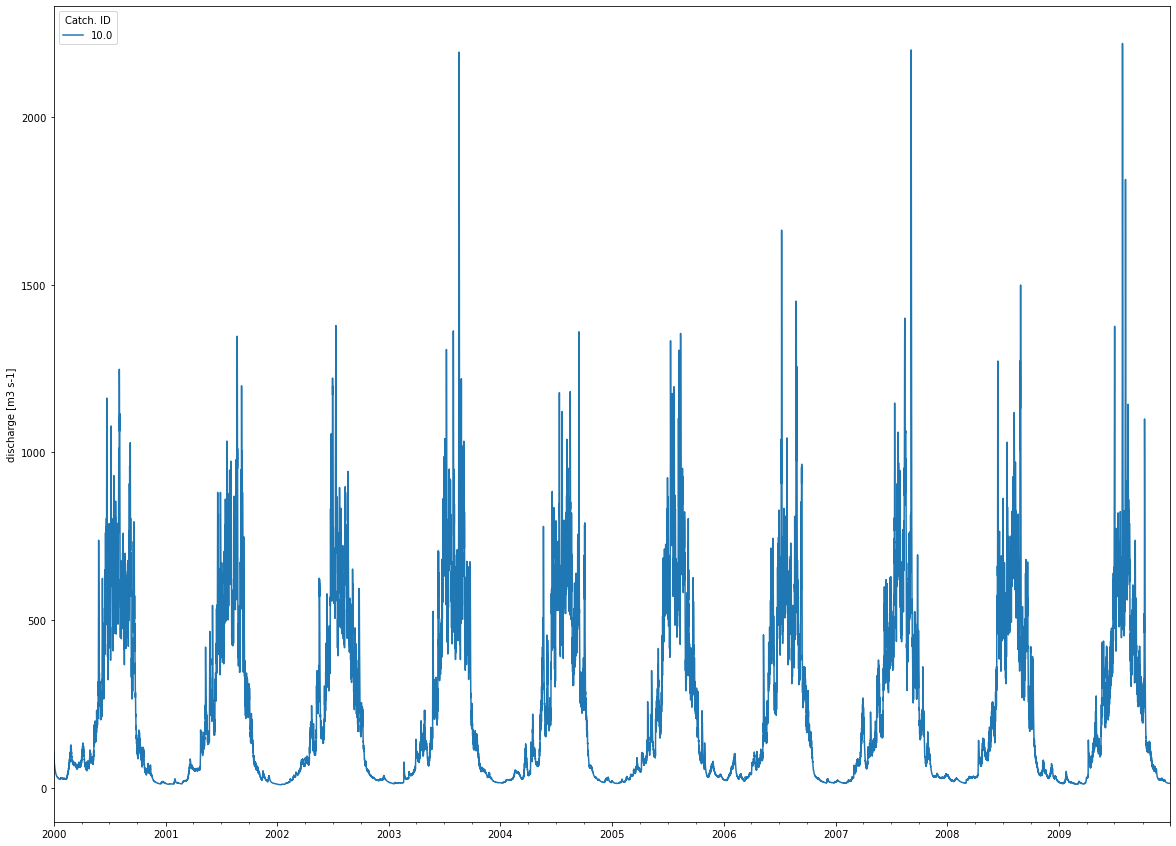

In [41]:
# First get the time-axis which we'll use as the index for the data frame
ta = simulator.region_model.time_axis
# and convert it to datetimes
timestamps = [ ta.time(i) for i in range(0, ta.n)]
#print(timestamps)
index = [datetime.datetime.utcfromtimestamp(p.seconds) for p in timestamps]

# Now we'll add all the discharge series for each catchment 
data = {}
for cid in catchment_id_map:
    # get the discharge time series for the subcatchment
    q_ts = simulator.region_model.statistics.discharge([int(cid)])
    data[cid] = q_ts.values.to_numpy()

df = pd.DataFrame(data, index=index)
# we can simply use:
ax = df.plot(figsize=(20,15))
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

In [46]:
# api.TsVector() is a list of api.Timeseries type. 
discharge_ts = api.TsVector() #  except from the type, it just works as a list()
# loop over each catchment, and extract the time-series (we keep them as such for now)
for cid in catchment_id_map: # fill in discharge time series for all subcatchments
    discharge_ts.append(simulator.region_model.statistics.discharge([int(cid)]))
    # discharge is a TS object,keeping a .time_axis and .values

Text(0, 0.5, 'discharge [m3 s-1]')

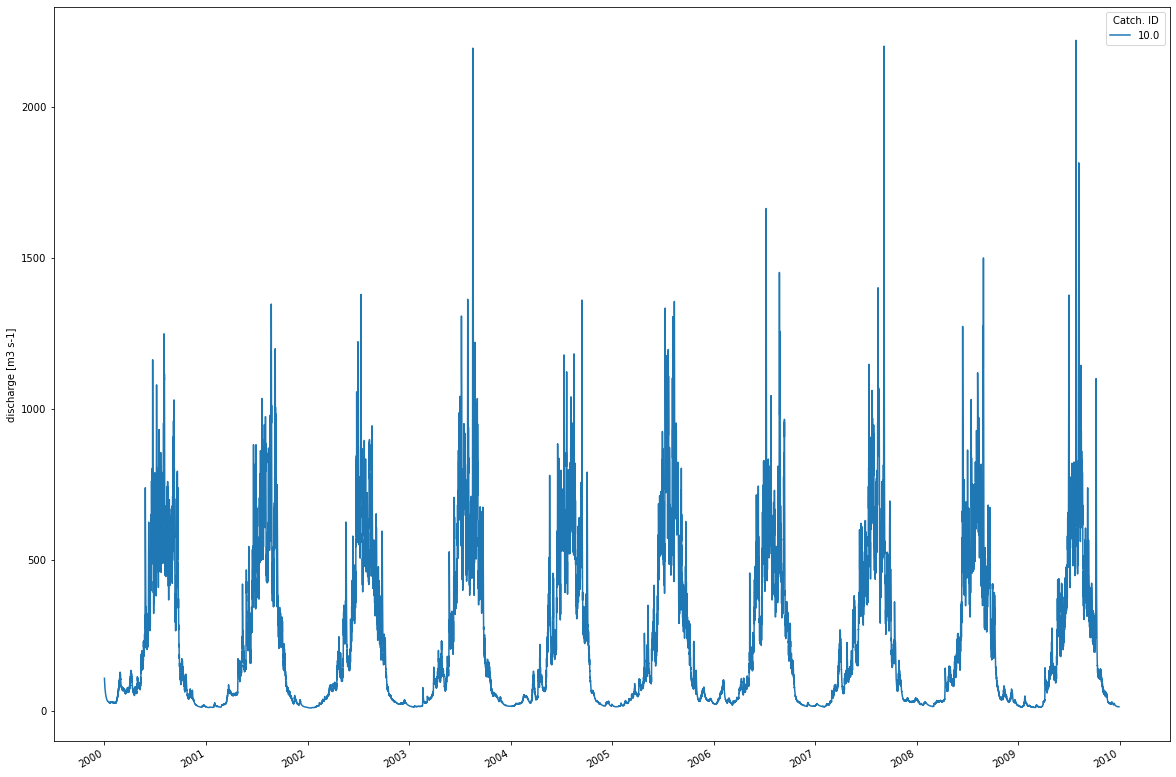

In [50]:
# We can make a quick plot of the data of each sub-catchment
fig, ax = plt.subplots(figsize=(20,15))

# plot each catchment discharge in the catchment_id_map
for i,ts in enumerate(discharge_ts):
    # a ts.time_axis can be enumerated to it's UtcPeriod, 
    # that will have a .start and .end of type utctimestamp
    # to use matplotlib support for datetime-axis, we convert it to datetime (as above)
    ts_timestamps = [datetime.datetime.utcfromtimestamp(p) for p in ts.time_axis.time_points]
    ts_values = ts.values # iterable and convertible, .to_numpy() makes an np array
    ax.plot(ts_timestamps[:-1],ts_values, label = "{}".format(catchment_id_map[i]))
fig.autofmt_xdate()
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

Text(0, 0.5, 'discharge [m3 s-1]')

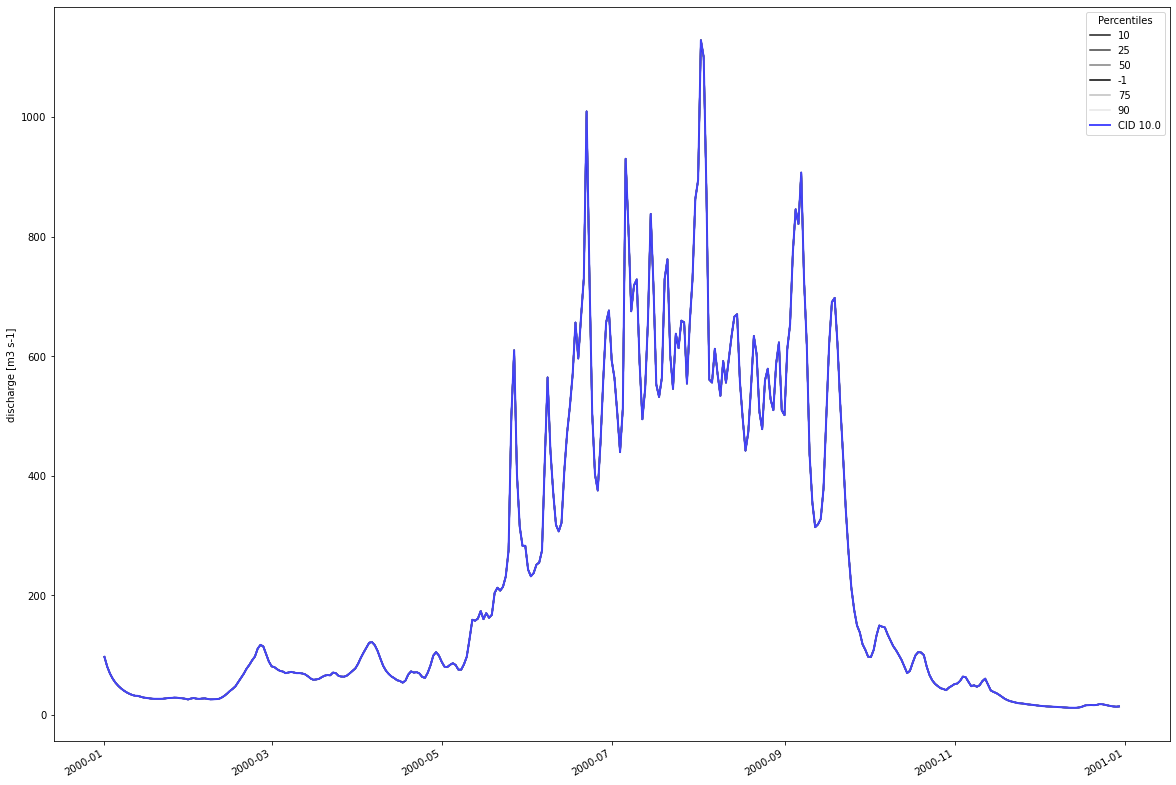

In [53]:
# First, we can also plot the statistical distribution of the 
# discharges over the sub-catchments

# get the percentiles we want, note -1 = arithmetic average
percentiles= api.IntVector([10,25,50,-1,75,90])  

# create a Daily(for the fun of it!) time-axis for the percentile calculations
# (our simulation could be hourly) 
ta_statistics = api.TimeAxis(simulator.region_model.time_axis.time(0),sts.Calendar.DAY,365)

# then simply get out a new set of time-series, corresponding to the percentiles we specified
# note that discharge_ts is of the api.TsVector type, not a simple list as in our first example above
discharge_percentiles = api.percentiles(discharge_ts,ta_statistics,percentiles)

#utilize that we know that all the percentile time-series share a common time-axis
common_timestamps = [datetime.datetime.utcfromtimestamp(p) for p in ta_statistics.time_points] 

# Then we can make another plot of the percentile data for the sub-catchments
fig, ax = plt.subplots(figsize=(20,15))

# plot each discharge percentile in the discharge_percentiles
for i,ts_percentile in enumerate(discharge_percentiles):
    clr='k'
    if percentiles[i] >= 0.0: 
        clr= str(float(percentiles[i]/100.0))
    ax.plot(common_timestamps[:-1], ts_percentile.values, label = "{}".format(percentiles[i]),color=clr)

# also plot catchment discharge along with the statistics
# notice that we use .average(ta_statistics) to properly align true-average values to time-axis
ax.plot(common_timestamps[:-1],discharge_ts[0].average(ta_statistics).values,label = "CID {}".format(catchment_id_map[0]),linewidth=2.0,alpha=0.7,color='b')

fig.autofmt_xdate()
ax.legend(title="Percentiles")
ax.set_ylabel("discharge [m3 s-1]")

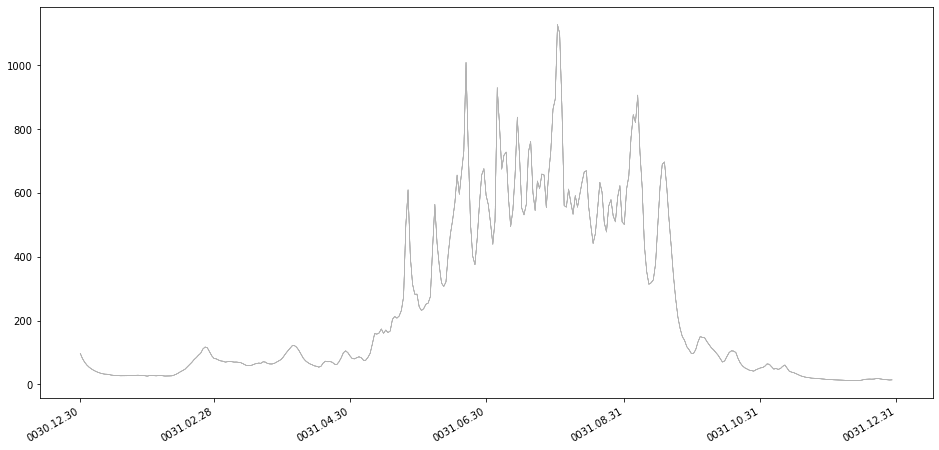

In [55]:
# a simple percentile plot, from orchestration looks nicer
from shyft.hydrology.orchestration import plotting as splt
oslo=sts.Calendar('Europe/Oslo')  # notice that we use olson tz-id to select time-zone
fig,ax=plt.subplots(figsize=(16,8))
splt.set_calendar_formatter(oslo) # notice how easy it is to ensure timestamp labels are tz aware
h,ph=splt.plot_np_percentiles(common_timestamps[:-1],[ p.values.to_numpy() for p in discharge_percentiles],base_color=(0.03,0.01,0.3))

In [56]:
cells = simulator.region_model.get_cells()

# Once we have the cells, we can get their coordinate information
# and fetch the x- and y-location of the cells
x = np.array([cell.geo.mid_point().x for cell in cells])
y = np.array([cell.geo.mid_point().y for cell in cells])

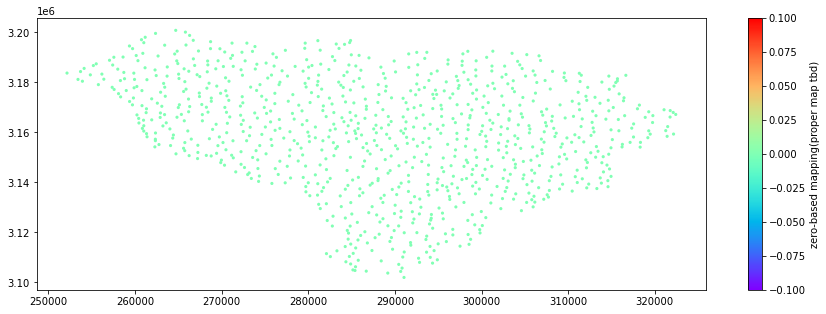

In [57]:
 # let's create the mapping of catchment_id to an integer:
cid_z_map = dict([ (catchment_id_map[i],i) for i in range(len(catchment_id_map))])

# then create an array the same length as our 'x' and 'y', which holds the
# integer value that we'll use for the 'z' value
catch_ids = np.array([cid_z_map[cell.geo.catchment_id()] for cell in cells])

# and make a quick catchment map...
# using a scatter plot of the cells
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('rainbow')
plot = ax.scatter(x, y, c=catch_ids, marker='.', s=40, lw=0, cmap=cm)
plt.colorbar(plot).set_label('zero-based mapping(proper map tbd)')

In [70]:
 #first, set a date: year, month, day, (hour of day if hourly time step)
oslo = sts.Calendar('Europe/Oslo') # specifying input calendar in Oslo tz-id
time_x = oslo.time(2010,1,15)  # the oslo calendar(incl dst) converts calendar coordinates Y,M,D.. to its utc-time

# we need to get the index of the time_axis for the time
try:
    idx = simulator.region_model.time_axis.index_of(time_x) # index of time x on time-axis
except:
    print("Date out of range, setting index to 0")
    idx = 0

# fetching SCA (the response variable is named "snow_sca")
# You can use tab-completion to explore the `rc`, short for "response collector"
# object of the cell, to see further response variables available.
# specifying empty list [] indicates all catchments, otherwise pass catchment_id
sca = simulator.region_model.gamma_snow_response.sca([],idx)

In [71]:
simulator.region_model.time_axis.index_of(time_x)



18446744073709551615

In [72]:
simulator.region_model.gamma_snow_response

Text(0.5, 1.0, 'Snow Covered area of budhi_gandaki-ptgsk-tin on 2010-01-15T00:00:00+01')

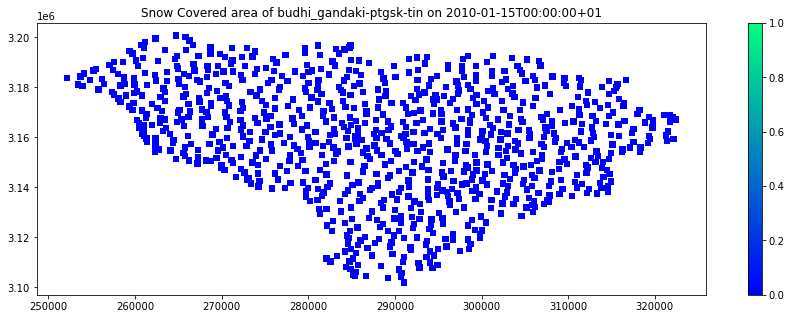

In [73]:
# We can make a simple scatter plot again for quick visualization
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('winter')
plot = ax.scatter(x, y, c=sca, 
                  vmin=0, vmax=1, 
                  marker='s', s=40, lw=0, 
                  cmap=cm)
plt.colorbar(plot)
plt.title('Snow Covered area of {0} on {1}'.format(cfg.region_model_id, oslo.to_string(time_x)))

Average SCA for Budhi Gandaki: 3.462496e-318


Text(0, 0.5, 'frequency')

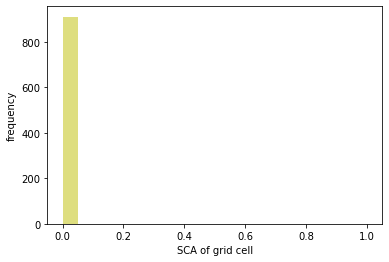

In [75]:
# look at the catchment-wide average:
avg_sca = np.average(sca)
print("Average SCA for Budhi Gandaki: {0}".format(nea_avg_sca))

# And let's compute histogram of the snow covered area as well
fig, ax = plt.subplots()
ax.hist(sca, bins=20, range=(0,1), color='y', alpha=0.5)
ax.set_xlabel("SCA of grid cell")
ax.set_ylabel("frequency")

In [25]:
#cf_region

__main__.CFRegionModelRepository

In [23]:
# def tin_region_model_repository() -> Any:
#     if os.name != 'nt':
#         from cf_region_model_repository_tin import CFRegionModelRepository
#         return CFRegionModelRepository
#     else:
#         raise RuntimeError("TIN models are only available for generation/testing on windows")

In [24]:
# tin_region_model_repo = tin_region_model_repository()

In [25]:
# tin_region_model_repo.cell_data_to_netcdf

<function cf_region_model_repository_tin.CFRegionModelRepository.cell_data_to_netcdf(self, region_model, output_dir)>

In [26]:
# @pytest.fixture
# def region() -> Dict:
#     return {'region_model_id': 'test',  # a unique name identifier of the simulation
#             'domain': {'EPSG': 32645,
#                        'nx': 1077,
#                        'ny': 1077,
#                        'step_x': 1000,
#                        'step_y': 1000,
#                        'lower_left_x': 251933,
#                        'lower_left_y': 3102291},
#             'repository': {'class': tin_region_model_repository(),
#                            'params': {
#                                'data_file': os.path.join(shyftdata_dir, 'netcdf/orchestration-testdata/tin_cell_data.nc'),
#                                #'data_file': os.path.abspath('netcdf/orchestration-testdata/tin_cell_data.nc'),
#                                'get_model_from_tin_repo': True,
#                                'tin_data_folder': os.path.abspath( "tin_archive/"),
#                                'tin_uid': ['narayani-cid-10-small'],  # tin_uid=filename=catchment_id, here use can use list to load all required sub-catchments
#                            }},
#             }



NameError: name 'pytest' is not defined

In [27]:
# region = region

In [7]:
# @pytest.fixture
# def model() -> Dict:
#     return {
#         'model_t': PTGSKModel,  # model to construct
#         'model_parameters': {
#             'ae': {
#                 'ae_scale_factor': 1.5},
#             'gs': {
#                 'calculate_iso_pot_energy': False,
#                 'fast_albedo_decay_rate': 6.752787747748934,
#                 'glacier_albedo': 0.4,
#                 'initial_bare_ground_fraction': 0.04,
#                 'max_albedo': 0.9,
#                 'max_water': 0.1,
#                 'min_albedo': 0.6,
#                 'slow_albedo_decay_rate': 37.17325702015658,
#                 'snow_cv': 0.4,
#                 'snow_cv_altitude_factor': 0.0,
#                 'snow_cv_forest_factor': 0.0,
#                 'tx': -0.5752881492890207,
#                 'snowfall_reset_depth': 5.0,
#                 'surface_magnitude': 30.0,
#                 'wind_const': 1.0,
#                 'wind_scale': 1.8959672005350063,
#                 'winter_end_day_of_year': 100},
#             'kirchner': {
#                 'c1': -3.336197322290274,
#                 'c2': 0.33433661533385695,
#                 'c3': -0.12503959620315988},
#             'p_corr': {
#                 'scale_factor': 1.0},
#             'pt': {'albedo': 0.2,
#                    'alpha': 1.26},
#             'routing': {
#                 'alpha': 0.9,
#                 'beta': 3.0,
#                 'velocity': 0.0}
#         }
#     }


# @pytest.fixture
# def region_model_repo(region, model) -> Any:
#     return tin_region_model_repository()(region, model)

In [8]:
# def test_get_region_model(region_model_repo):
#     assert isinstance(region_model_repo.get_region_model('test'), PTGSKModel), 'Correct model type not returned from CFRegionModelRepository'


# def test_cell_data_to_netcdf(region_model_repo, region, model):
#     region_model = region_model_repo.get_region_model('test')
#     with tempfile.TemporaryDirectory() as test_dir:
#         region_model_repo.cell_data_to_netcdf(region_model, os.path.join(test_dir, 'test'))
#         # open the file and be sure it works
#         output_nc = os.path.join(test_dir, 'test_cell_data.nc')
#         region['repository']['params']['data_file'] = output_nc
#         tmp_rm = tin_region_model_repository()(region, model).get_region_model('test')
#         assert isinstance(tmp_rm, PTGSKModel), f'Error with {output_nc}'